In [20]:
import pyxdf
import os
import mne
mne.viz.set_browser_backend('matplotlib')  # or 'matplotlib' 'qt', etc.
import matplotlib.pyplot as plt
matplotlib.style.use('default')
%matplotlib inline
import numpy as np
from utils import closest_points_vector, split_video, create_mappings, create_events, create_mne

In [ ]:
EXP_ROOT = "exp_data"
INPUT_ROOT = "input"
OUTPUT_ROOT = "output"
sub_id = 797337
DATA_FILE = os.path.join(
    EXP_ROOT, f"sub-{sub_id}", f"sub-{sub_id}_task-hearing_run-001.xdf"
)
RAW_VIDEO = os.path.join(EXP_ROOT, f"sub-{sub_id}", f"{sub_id}.avi")
data, header = pyxdf.load_xdf(DATA_FILE)
marker_stream = next(
    stream for stream in data if stream["info"]["type"][0] == "Markers"
)
video_stream = next(stream for stream in data if stream["info"]["type"][0] == "Video")
eeg_stream = next(stream for stream in data if stream["info"]["type"][0] == "EEG")

In [18]:
ch_labels = ['L1', 'L2', 'L4', 'L5', 'L7', 'L8', 'L9', 'L10',
             'R1', 'R2', 'R4', 'R5', 'R7', 'R8', 'R9', 'R10']
sampling_rate = 125

eeg_data = eeg_stream['time_series'].swapaxes(1, 0)
info = mne.create_info(
    ch_names=ch_labels, sfreq=sampling_rate, ch_types='eeg')
bindings = ['pmt', 'hlt', 'let', 'ast']
marker_data = np.array(marker_stream["time_series"]).squeeze()

marker_timestamps = marker_stream["time_stamps"]

eeg_insert_points = closest_points_vector(eeg_stream['time_stamps'], marker_timestamps)

marker_dict, id_binding, category_mapping = create_mappings(
    marker_data, bindings)
events = create_events(eeg_insert_points, marker_dict, marker_data)
bandpass = {"low": 1, "high": 50}
flat_voltage = 0.1
raw = create_mne(eeg_stream, events, id_binding,
                    bandpass=bandpass, flat_voltage=flat_voltage)

Creating RawArray with float64 data, n_channels=16, n_times=170520
    Range : 0 ... 170519 =      0.000 ...  1364.152 secs
Ready.
Finding segments below or above PTP threshold.
Bad channels: ['R7']
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 825 samples (6.600 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method

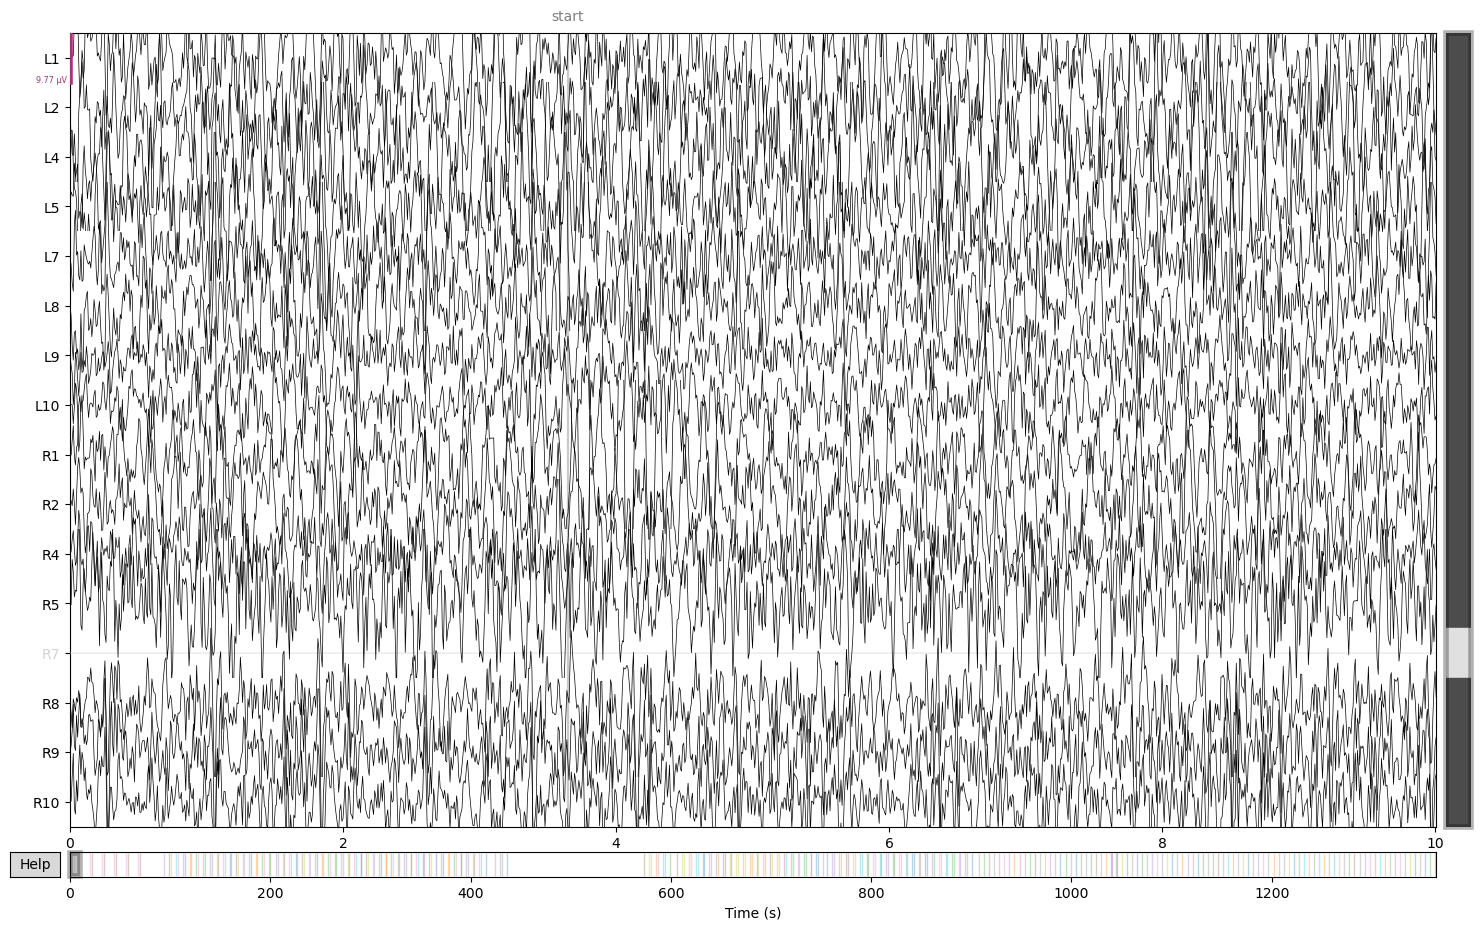

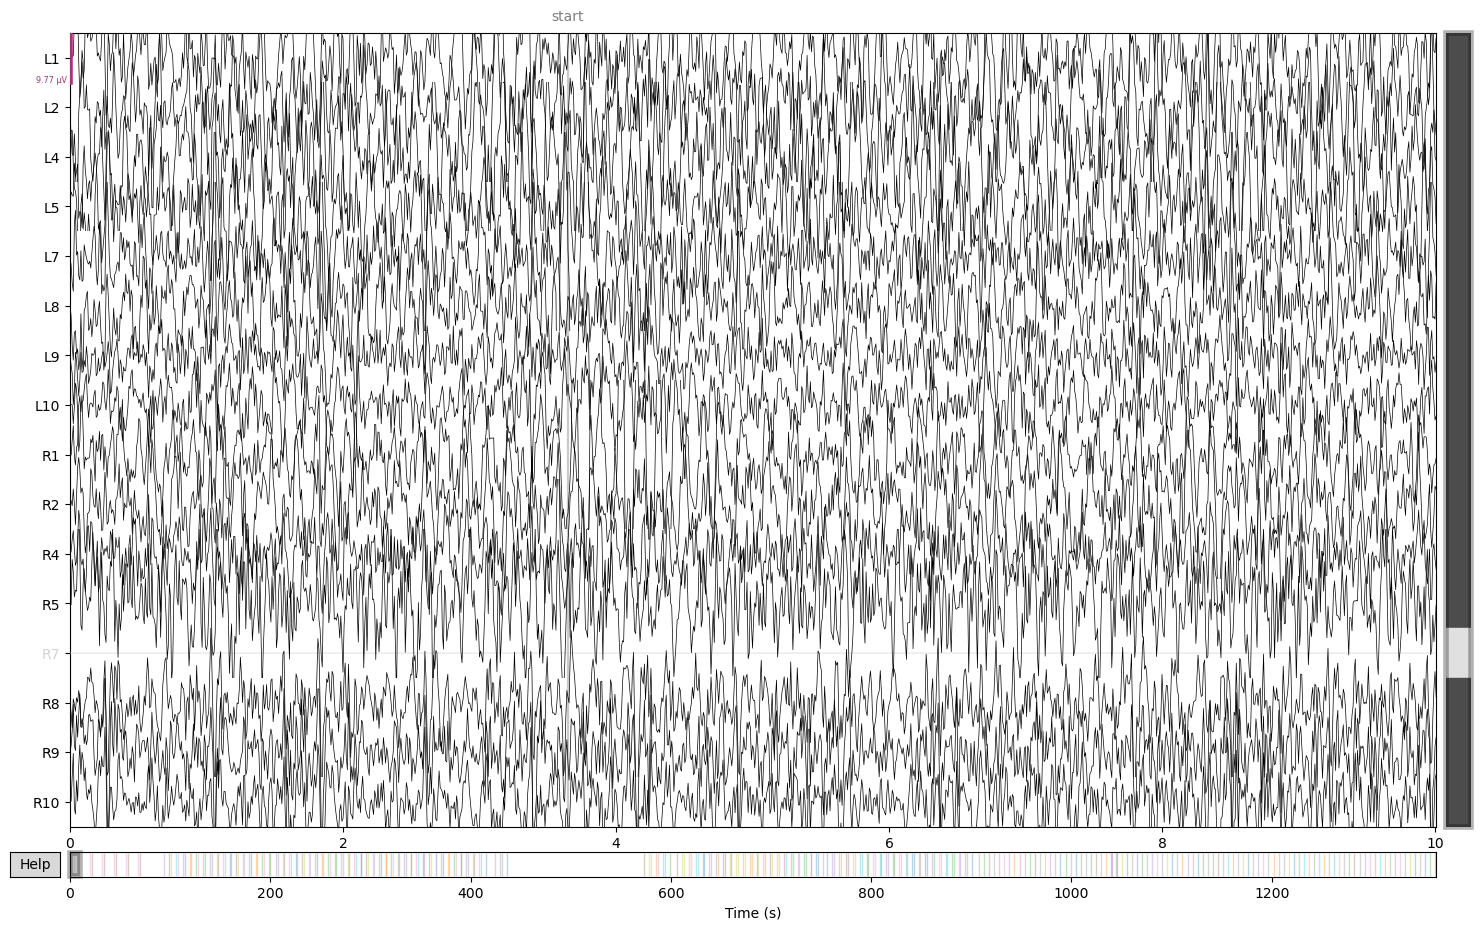

In [21]:
raw.plot(scalings='auto')

In [28]:
video_frames = video_stream["time_series"].squeeze()
insert_points = closest_points_vector(
    video_stream["time_stamps"], marker_stream["time_stamps"]
)
segments = []
for i in range(len(insert_points) - 1):
    start = insert_points[i]
    end = insert_points[i + 1] if i + 1 < len(insert_points) else -1
    segments.append(video_frames[start:end])

segments = segments
segment_arr = [(segments[i][0], segments[i][-1], marker_data[i]) for i in range(len(segments))]
print(segment_arr)

[(np.float32(132.0), np.float32(618.0), np.str_('start')), (np.float32(619.0), np.float32(678.0), np.str_('pmt_stim')), (np.float32(679.0), np.float32(976.0), np.str_('pmt_poststim')), (np.float32(977.0), np.float32(1037.0), np.str_('pmt_stim')), (np.float32(1038.0), np.float32(1335.0), np.str_('pmt_poststim')), (np.float32(1336.0), np.float32(1395.0), np.str_('pmt_stim')), (np.float32(1396.0), np.float32(1694.0), np.str_('pmt_poststim')), (np.float32(1695.0), np.float32(1754.0), np.str_('pmt_stim')), (np.float32(1755.0), np.float32(2053.0), np.str_('pmt_poststim')), (np.float32(2054.0), np.float32(2113.0), np.str_('pmt_stim')), (np.float32(2114.0), np.float32(2831.0), np.str_('pmt_poststim')), (np.float32(2832.0), np.float32(2980.0), np.str_('hlt_prestim-tone_3dB')), (np.float32(2981.0), np.float32(3040.0), np.str_('hlt_stim-tone_3dB')), (np.float32(3041.0), np.float32(3189.0), np.str_('hlt_poststim-tone_3dB')), (np.float32(3190.0), np.float32(3245.0), np.str_('hlt_response-tone_3dB')

In [ ]:
split_video(RAW_VIDEO, segment_arr, OUTPUT_ROOT)

In [29]:
for s in segment_arr:
    print(f"Start: {s[0]:.2f}, End: {s[1]:.2f}, Marker: {s[2]}, Duration: {(s[1]-s[0])/30:.2f}")

Start: 132.00, End: 618.00, Marker: start, Duration: 16.20
Start: 619.00, End: 678.00, Marker: pmt_stim, Duration: 1.97
Start: 679.00, End: 976.00, Marker: pmt_poststim, Duration: 9.90
Start: 977.00, End: 1037.00, Marker: pmt_stim, Duration: 2.00
Start: 1038.00, End: 1335.00, Marker: pmt_poststim, Duration: 9.90
Start: 1336.00, End: 1395.00, Marker: pmt_stim, Duration: 1.97
Start: 1396.00, End: 1694.00, Marker: pmt_poststim, Duration: 9.93
Start: 1695.00, End: 1754.00, Marker: pmt_stim, Duration: 1.97
Start: 1755.00, End: 2053.00, Marker: pmt_poststim, Duration: 9.93
Start: 2054.00, End: 2113.00, Marker: pmt_stim, Duration: 1.97
Start: 2114.00, End: 2831.00, Marker: pmt_poststim, Duration: 23.90
Start: 2832.00, End: 2980.00, Marker: hlt_prestim-tone_3dB, Duration: 4.93
Start: 2981.00, End: 3040.00, Marker: hlt_stim-tone_3dB, Duration: 1.97
Start: 3041.00, End: 3189.00, Marker: hlt_poststim-tone_3dB, Duration: 4.93
Start: 3190.00, End: 3245.00, Marker: hlt_response-tone_3dB, Duration: 1